# Setup

Setup by loading relevant modules and iPython extensions.

In [1]:
# Core 
import datetime
import os
import glob

# Analysis 
import xarray as xr
import numpy as np
import pyproj as pp
import scipy as sp
import transect_analysis as ta

# Plotting 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as mticker
from matplotlib.animation import FuncAnimation

# Debugging 
import pdb
%load_ext line_profiler

Define transects.

In [2]:
# Specify start and end coords on coast.
# Choose order so that (transect_axis, coastline_axis) forms a right hand coordinate system
lon0 = 134.5293 
lat0 = -12.4715
coast_lon1 = 133.3290
coast_lat1 = -12.1468

trans_lon0, trans_lat0, trans_lon1, trans_lat1, n_points, n_trans, coast_distances, tran_distances = ta.define_transects(
    lon0, lat0, coast_lon1, coast_lat1, 453300
)

static_path = '/g/data/ua8/ARCCSS_Data/MCASClimate/v1-0/static/static.nc'
static = xr.open_dataset(static_path).sel(latitude=slice(-12.75,-6), longitude=slice(130,139))
static_tran = ta.calc_transects(static, trans_lon0, trans_lat0, trans_lon1, trans_lat1, n_points, n_trans) 
static_tran = static_tran.assign_coords(coastal_axis = coast_distances)
static_tran = static_tran.assign_coords(transect_axis = tran_distances)

# Calcualate distance where landmask drops below 0.5
coast_i = np.where(static_tran.mean('coastal_axis').LANDMASK.values < 0.5)[0][0] - 1
coast_location = tran_distances[coast_i]

# Redefine tran_distances so that coastline occurs at 0.
tran_distances = tran_distances - coast_location

# Create basis vectors of new coordinate system
b_lon = trans_lon1[0] - lon0
b_lat = trans_lat1[0] - lat0

Plot map of transects.

In [92]:
# Load WRF December mean data
WRF_mean = xr.open_mfdataset('/g/data/w40/esh563/goulburn_NT/*_December_mean.nc')
WRF_mean = WRF_mean.assign_coords(level = np.loadtxt('average_model_levels.txt'))
WRF_mean = WRF_mean.sel(level=slice(0, 15.5*10**3))

# Calcualate speed
speed = np.sqrt(WRF_mean.U ** 2 + WRF_mean.V ** 2)

# Define maximum level to plot
max_level = 8000

# Initialise fonts
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'font.size': 12})

# Initialise figure
plt.ioff()
plt.close('all')
fig = plt.figure(figsize=(5,5))

# Define map boundaries
lon_min = 131.0
lon_max = 138.0
lat_min = -12.6
lat_max = -6

# Set up cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(
    [lon_min, lon_max, lat_min, lat_max], 
    crs=ccrs.PlateCarree()
)
ax.coastlines(resolution='50m')

# Draw speed contours
speed_max = np.ceil(np.amax(speed.sel(level = slice(0,max_level)).values)*2)/2

levels = np.arange(0, speed_max+.5, 0.5)

speed_contour = ax.contourf(
    speed.longitude, speed.latitude, speed.isel(level = 0), levels=levels,
    vmin=0, vmax=speed_max, cmap='Reds', transform=ccrs.PlateCarree()
)
cbar_w = plt.colorbar(speed_contour, orientation='horizontal')
cbar_w.set_label('Wind Speed [m/s]')

# Draw arrows every half degree lon and lat
arrow_step = 0.75

U_quiver = WRF_mean.U.sel(
    latitude = np.arange(lat_min + arrow_step/2, lat_max + arrow_step/2, arrow_step), 
    longitude = np.arange(lon_min + arrow_step/2, lon_max + arrow_step/2, arrow_step),
    method = 'nearest'
)
V_quiver = WRF_mean.V.sel(
    latitude = np.arange(lat_min, lat_max, arrow_step), 
    longitude = np.arange(lon_min, lon_max, arrow_step),
    method = 'nearest'
)

ax.quiver(
    U_quiver.longitude, 
    U_quiver.latitude, 
    U_quiver.isel(level = i), V_quiver.isel(level = 0), 
    units='xy', angles='xy', transform=ccrs.PlateCarree(),
    scale=speed_max/arrow_step
)

# Draw grid
grid = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.4, linestyle='--',
)

grid.xlabels_top = False
grid.ylabels_right = False

grid.xlocator = mticker.FixedLocator(
    np.arange(np.floor(lon_min), np.ceil(lon_max)+2, 2)
)
grid.ylocator = mticker.FixedLocator(
    np.arange(np.floor(lat_min), np.ceil(lat_max)+2, 2)
)

grid.xformatter = LONGITUDE_FORMATTER
grid.yformatter = LATITUDE_FORMATTER

# Draw transects
for k in np.arange(0,np.size(trans_lon0),3):
    ax.plot(
            [trans_lon0[k], trans_lon1[k]], [trans_lat0[k], trans_lat1[k]],
            transform=ccrs.PlateCarree(),
            color='black', linewidth=.75
    )
    
# Make labels
plt.title('December Mean Wind [m/s] \n 2004 to 2014  \n {:.3f} km'.format(speed.level.values[i]/1000))
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Create directory for saving figures
dt=str(datetime.datetime.now())[0:-7]
dt=dt.replace(" ", "_")
dt=dt.replace(":", "_")
dt=dt.replace("-", "")         

directory = '/g/data/w40/esh563/goulburn_NT/' + dt

os.mkdir(directory)

# Define animation update function
def update(i):
    
    # Clear axis collections
    # ax.collections = []

    # Update contour
    speed_contour = ax.contourf(
        speed.longitude, speed.latitude, speed.isel(level = i), levels=levels,
        vmin=0, vmax=speed_max, cmap='Reds', transform=ccrs.PlateCarree()
    )

    # Update quiver
    ax.quiver(
        U_quiver.longitude, 
        U_quiver.latitude, 
        U_quiver.isel(level = i), V_quiver.isel(level = i), 
        units='xy', angles='xy', transform=ccrs.PlateCarree(),
        scale=speed_max/arrow_step
    )

    # Update title
    plt.title('Mean Wind December 2012 [m/s] \n' + '{:.3f} km'.format(speed.level[i].values/1000))
        
    # Save frame
    plt.savefig(
        directory + '/{}.png'.format(str(int(speed.level.values[i])))
    )

    return speed_contour, ax

# Create and save animation
anim = FuncAnimation(
    fig, update, interval=200,
    frames=np.arange(0, np.where(speed.level.values < max_level)[0][-1]))

anim.save(directory + '/mean_wind.gif', dpi=80, writer='imagemagick')

# Transects

Open transect files.

In [27]:
i = 13
base = '/g/data/w40/esh563/goulburn_NT/20{}20{}'.format(str(i).zfill(2), str(i+1).zfill(2))

U_path = base + '/U/U_goulburn_20{}12*.nc'.format(str(i).zfill(2))
V_path = base + '/V/V_goulburn_20{}12*.nc'.format(str(i).zfill(2))

['/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131221.nc',
 '/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131207.nc',
 '/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131210.nc',
 '/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131225.nc',
 '/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131227.nc',
 '/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131203.nc',
 '/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131229.nc',
 '/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131213.nc',
 '/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131217.nc',
 '/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131223.nc',
 '/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131218.nc',
 '/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131214.nc',
 '/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131222.nc',
 '/g/data/w40/esh563/goulburn_NT/20132014/U/U_goulburn_20131220.nc',
 '/g/data/w40/esh563/goulburn_NT/2

In [65]:
proj_tran_i = xr.open_mfdataset(
    [
        '/g/data/w40/esh563/goulburn_NT/transects/wind_proj_goulburn_201312.nc',
        '/g/data/w40/esh563/goulburn_NT/transects/wind_proj_goulburn_201312.nc',
    ],
    chunks={'time' : 1488}
)

ValueError: cannot infer dimension to concatenate: supply the ``concat_dim`` argument explicitly

In [56]:
proj_tran_i = (proj_tran_i - proj_tran_i.rolling(time=24, center=True).mean()).dropna('time')
proj_tran_i = proj_tran_i.mean(dim='coastal_axis')
proj_tran_i = proj_tran_i.groupby('time.hour').mean('time')

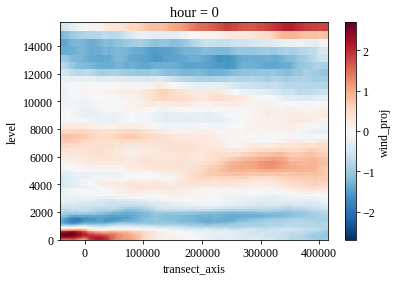

In [63]:
proj_tran_i.wind_proj.isel(hour = 0).plot()
plt.show()

# Create Composites

In [33]:
for i in np.arange(14,15)

    proj_tran_i = xr.open_dataset('/g/data/w40/esh563/goulburn_NT/transects/wind_proj_goulburn_201412.nc') 
    
    # Sutract 24 hour running mean
    proj_tran = (proj_tran - proj_tran.rolling(time=24, center=True).mean()).dropna('time')
    W_tran = (W_tran - W_tran.rolling(time=24, center=True).mean()).dropna('time')
    T_tran = (T_tran - T_tran.rolling(time=24, center=True).mean()).dropna('time')

    # Average over coastal_axis, i.e. over multiple transects
    proj_tran = proj_tran.mean(dim='coastal_axis')
    W_tran = W_tran.mean(dim='coastal_axis')
    T_tran = T_tran.mean(dim='coastal_axis')

    # Create a composite
    proj_tran_list = [proj_tran.where(proj_tran['wind_proj']['time.hour'] == 0).mean('time', skipna=True)] * 24
    W_tran_list = [W_tran.where(W_tran['W']['time.hour'] == 0).mean('time', skipna=True)] * 24
    T_tran_list = [T_tran.where(T_tran['T']['time.hour'] == 0).mean('time', skipna=True)] * 24

    for i in range(1,24):
        proj_tran_list[i] = proj_tran.where(proj_tran['wind_proj']['time.hour'] == i).mean('time', skipna=True)
        W_tran_list[i] = W_tran.where(W_tran['W']['time.hour'] == i).mean('time', skipna=True)
        T_tran_list[i] = T_tran.where(T_tran['T']['time.hour'] == i).mean('time', skipna=True)

    proj_tran_h = xr.concat(proj_tran_list, dim = 'hour_UTC')
    proj_tran_h = proj_tran_h.assign_coords(hour_UTC = np.arange(0,24))    

    W_tran_h = xr.concat(W_tran_list, dim = 'hour_UTC')
    W_tran_h = W_tran_h.assign_coords(hour_UTC = np.arange(0,24)) 

    T_tran_h = xr.concat(T_tran_list, dim = 'hour_UTC')
    T_tran_h = T_tran_h.assign_coords(hour_UTC = np.arange(0,24))

    proj_tran_h.to_netcdf(
        path='/g/data/w40/esh563/goulburn_NT/wind_proj_c_goulburn_201412.nc', mode='w', format='NETCDF4'
    )
    W_tran_h.to_netcdf(
        path='/g/data/w40/esh563/goulburn_NT/W_c_goulburn_201412.nc', mode='w', format='NETCDF4'
    )
    T_tran_h.to_netcdf(
        path='/g/data/w40/esh563/goulburn_NT/T_c_goulburn_201412.nc', mode='w', format='NETCDF4'
    )

SyntaxError: invalid syntax (<ipython-input-33-aee60b5f835e>, line 1)

# Plot

In [34]:
plt.ioff()

print('Animating velocity.')

LST = (np.arange(0,24) + 9) % 24

# Initialise fonts
rcParams['font.family'] = 'serif'
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'font.size': 12})
rcParams.update({'font.weight': 'normal'})

fig, ax = plt.subplots()

plt.plot(
    [0, 0], [proj_tran_h.level[0], proj_tran_h.level[57]],
    '--', color='grey')

speed_max=np.ceil(np.amax(np.abs(proj_tran_h.wind_proj[:,0:58,:].values))/2)*2
levels=np.arange(-speed_max, speed_max+1)

contour_plot = ax.contourf(
    proj_tran_h.transect_axis, proj_tran_h.level[0:58], 
    proj_tran_h.wind_proj.values[0,0:58,:],
    levels, vmin=-speed_max, vmax=speed_max, cmap='RdBu_r')

heights = np.arange(proj_tran_h.level[0],proj_tran_h.level[58],500)
distances = np.arange(proj_tran_h.transect_axis[0],proj_tran_h.transect_axis[-1], 25000)

cbar=plt.colorbar(contour_plot)
cbar.set_label('Perturbation Velocity [m/s]')

proj_tran_quiver = proj_tran_h.interp(transect_axis = distances).interp(level = heights)
W_tran_quiver = W_tran_h.interp(transect_axis = distances).interp(level = heights)
 
ax.quiver(
    proj_tran_quiver.transect_axis, 
    proj_tran_quiver.level, 
    proj_tran_quiver.wind_proj.values[0,:,:], W_tran_quiver.W.values[0,:,:], 
    units='xy', angles='xy', scale=0.00015)

plt.title('Perturbation Velocity [m/s]')
plt.xlabel('Distance [m]')
plt.ylabel('Height [m]')

dt=str(datetime.datetime.now())[0:-7]
dt=dt.replace(" ", "_")
dt=dt.replace(":", "_")
dt=dt.replace("-", "")         

directory = '/g/data/w40/esh563/goulburn_NT/' + dt

os.mkdir(directory)

def update(i):
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    ax.collections = []
    
    print('Plotting frame ' + str(i) + '.')

    contourPlot=ax.contourf(
        proj_tran_h.transect_axis, proj_tran_h.level[0:58], 
        proj_tran_h.wind_proj.values[i,0:58,:],
        levels, vmin=-speed_max, vmax=speed_max, cmap='RdBu_r'
    )

    ax.quiver(
        proj_tran_quiver.transect_axis, 
        proj_tran_quiver.level, 
        proj_tran_quiver.wind_proj.values[i,:,:], W_tran_quiver.W.values[i,:,:], 
        units='xy', angles='xy', scale=0.00015
    )
                            
    ax.plot(
        [0, 0], [proj_tran_h.level[0], proj_tran_h.level[57]],
        '--', color='grey'
    )
    
    plt.title('Perturbation Velocity [m/s] \n' + str(LST[i]).zfill(2) + ':00 LST')
        
    plt.savefig(directory + '/' + str(LST[i]) + '.png')

    return contourPlot, ax

anim = FuncAnimation(fig, update, frames=np.arange(0, 24),interval=200)
anim.save(directory + '/velocity.gif', dpi=80, writer='imagemagick')

plt.close('all')

Animating velocity.


NameError: name 'proj_tran_h' is not defined

In [339]:
i = 0

fig, ax = plt.subplots(figsize=[4,7], tight_layout=True)
# Plot
plt.rc('text', usetex=False)

# Initialise fonts
rcParams['font.family'] = 'serif'
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'font.size': 12})
rcParams.update({'font.weight': 'normal'})

LST = np.arange(-24,48) + 9
z = np.concatenate([np.squeeze(proj_tran_h.wind_proj.values[:,i,:])]*3, axis=0)

LST = LST[15:48+15]
z = z[15:48+15,:]

plt.plot([0, 0], [0, 47], '--', color='grey')

plt.title(
    'Velocity Anomaly [m/s] \n' + '{:.3f} km'.format(proj_tran_h.level.values[i]/1000)
)
plt.xlabel('Distance [m]')
plt.ylabel('Time [h LST]')

contour_w = ax.contourf(
    proj_tran_h.transect_axis.values, LST, z,
    cmap='RdBu_r', levels = np.arange(-4.5,5.0,0.5),
)

plt.yticks(np.arange(0, 48, step=6))

cbar_w=plt.colorbar(contour_w, orientation='horizontal')
cbar_w.set_label('Velocity Anomaly [m/s]')

dt=str(datetime.datetime.now())[0:-7]
dt=dt.replace(" ", "_")
dt=dt.replace(":", "_")
dt=dt.replace("-", "")         

directory = '/g/data/w40/esh563/goulburn_NT/' + dt

os.mkdir(directory)

def update(i):
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    ax.collections = []
    
    print('Plotting frame ' + str(i) + '.')
    
    z = np.concatenate([np.squeeze(proj_tran_h.wind_proj.values[:,i,:])]*3, axis=0)
    z = z[15:48+15,:]

    contour_w = ax.contourf(
        proj_tran_h.transect_axis.values, LST, z,
        cmap='RdBu_r', levels = np.arange(-4.5,5.0,0.5),
    )
                            
    plt.plot([0, 0], [0, 47], '--', color='grey')
    
    plt.title(
        'Velocity Anomaly [m/s] \n' + '{:.3f} km'.format(proj_tran_h.level.values[i]/1000)
    )
        
    plt.savefig(
        directory + '/' + str(int(proj_tran_h.level.values[i])) + '.png'
    )

    return contour_w, ax

anim = FuncAnimation(fig, update, frames=np.arange(0, proj_tran_h.level.size),interval=200)
anim.save(directory + '/velocity_hov.gif', dpi=80, writer='imagemagick')

plt.close('all')

Plotting frame 0.
Plotting frame 0.
Plotting frame 1.
Plotting frame 2.
Plotting frame 3.
Plotting frame 4.
Plotting frame 5.
Plotting frame 6.
Plotting frame 7.
Plotting frame 8.
Plotting frame 9.
Plotting frame 10.
Plotting frame 11.
Plotting frame 12.
Plotting frame 13.
Plotting frame 14.
Plotting frame 15.
Plotting frame 16.
Plotting frame 17.
Plotting frame 18.
Plotting frame 19.
Plotting frame 20.
Plotting frame 21.
Plotting frame 22.
Plotting frame 23.
Plotting frame 24.
Plotting frame 25.
Plotting frame 26.
Plotting frame 27.
Plotting frame 28.
Plotting frame 29.
Plotting frame 30.
Plotting frame 31.
Plotting frame 32.
Plotting frame 33.
Plotting frame 34.
Plotting frame 35.
Plotting frame 36.
Plotting frame 37.
Plotting frame 38.
Plotting frame 39.
Plotting frame 40.
Plotting frame 41.
Plotting frame 42.
Plotting frame 43.
Plotting frame 44.
Plotting frame 45.
Plotting frame 46.
Plotting frame 47.
Plotting frame 48.
Plotting frame 49.
Plotting frame 50.
Plotting frame 51.
Plot